In [33]:
IDENTIFIER = "haydn-op1"
NUM = 3

import json
import networkx as nx
import pandas as pd
from dwave.system import DWaveSampler, FixedEmbeddingComposite

from plots import plotCSV
from qubo import createBQM
from samples import firstValid, totalEntropy, duplicates, overlaps, extractChosen


picklePath = f"../Pickles/{IDENTIFIER}/{IDENTIFIER}_"
numPath = f"../Pickles/{IDENTIFIER}/{NUM}/{IDENTIFIER}_{NUM}_"
dataPath = f"../Data/{IDENTIFIER}/{NUM}/{IDENTIFIER}_{NUM}_"

phrases = pd.read_csv(picklePath + "phrases.csv", index_col=[0,1])
G = nx.read_graphml(picklePath + "graph.graphml")
instruments = json.load(open(numPath + "instruments.json"))
embedding = json.load(open(numPath + "embedding.json", "r"))
qa = FixedEmbeddingComposite(DWaveSampler(), embedding)

In [11]:
bqm = createBQM(G, phrases, instruments, 6, 12, 1)
sampleset = qa.sample(bqm, num_reads=100, label=f"{IDENTIFIER}_{NUM}")

In [30]:
sampleset.to_pandas_dataframe(True).sort_values("energy").head()
s = sampleset.first.sample

print(duplicates(s, G))
print(overlaps(s, G))

#print(sampleset.filter(lambda d: duplicates(d.sample, G) == 0))
print(sampleset.info)

1
2
{'timing': {'qpu_sampling_time': 26982.0, 'qpu_anneal_time_per_sample': 20.0, 'qpu_readout_time_per_sample': 229.24, 'qpu_access_time': 42746.76, 'qpu_access_overhead_time': 2531.24, 'qpu_programming_time': 15764.76, 'qpu_delay_time_per_sample': 20.58, 'post_processing_overhead_time': 53.0, 'total_post_processing_time': 53.0}, 'problem_id': '3a3e870d-ba00-44b8-9b6a-357536dff328', 'problem_label': 'beethoven-op67_4'}


In [35]:
def recordChainStrength(strengthRange, bqm, filepath: str) -> None:
    
    file = pd.DataFrame()
    reads = 1000

    for s in strengthRange:
        sampleset = qa.sample(bqm, num_reads=reads, chain_strength=s, label=f"{IDENTIFIER}_{NUM}_cs={s}")
        sample = sampleset.first

        new_row = pd.DataFrame({
            #"Chain strength": [sampleset.info["embedding_context"]["chain_strength"]],
            "Chain strength": [s],
            "Total reads": [reads],
            "Time": [sampleset.info["timing"]["qpu_access_time"]],
            "Chain break fraction": [sample.chain_break_fraction],
            "Lowest energy": [bqm.energy(sample.sample)],
            "Total entropy": [totalEntropy(sample.sample, G)],
            "Overlaps": [overlaps(sample.sample, G)],
            "Duplicates": [duplicates(sample.sample, G)]
            })
    
        print(f"Chain strength {s} recorded!")
        file = pd.concat([file, new_row])

    file.to_csv(filepath, index=False, mode="a", header=False)

# 10 to 50 repeated 
chainStrengths = range(40,51)
bqm = createBQM(G, phrases, instruments, 6, 6, 1) # CHANGE
recordChainStrength(chainStrengths, bqm, dataPath+"chain-strength.csv")

Chain strength 40 recorded!
Chain strength 41 recorded!
Chain strength 42 recorded!
Chain strength 43 recorded!
Chain strength 44 recorded!
Chain strength 45 recorded!
Chain strength 46 recorded!
Chain strength 47 recorded!
Chain strength 48 recorded!
Chain strength 49 recorded!
Chain strength 50 recorded!


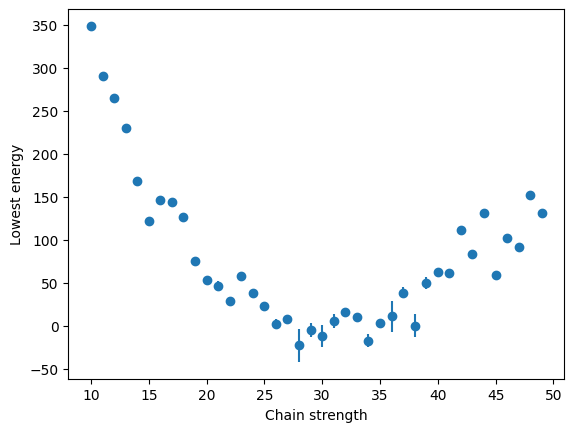

In [29]:
plotCSV(dataPath+"chain-strength.csv", "Chain strength", "Lowest energy", "tab:blue")

# ~25 optimal???
# chain_break_method=chain_breaks.discard?????
# Don't care about chain breaks, only valid solutions

`haydn-op1` = 25

`beethoven-op67` = 30